# Extraction of Watson Assistant Logs from Workspace

####  Author Omar Megawer
2018-Mar-09

In [64]:
!pip install pixiedust
!pip install update watson-developer-cloud

In [1]:
import pandas as pd
from watson_developer_cloud import AssistantV1
import numpy as np
from sklearn.model_selection import KFold
import pixiedust
import json
from urllib.parse import urlparse, parse_qs
import itertools
import matplotlib.pyplot as plt
import datetime, dateutil.parser
import seaborn as sns
%matplotlib inline
import warnings
import openpyxl
import pytz
server_timezone = pytz.timezone("Etc/GMT+1")
uae_timezone = pytz.timezone("Asia/Dubai")

warnings.filterwarnings("ignore")

Pixiedust database opened successfully


##### Add the Watson Conversation credentials

In [10]:
ctx = {
  "url": "https://gateway-lon.watsonplatform.net/assistant/api",
  "username": "apikey",
  "password": ""
}

workspace_id = "83bc687f-"


##### Logs Extraction

In [11]:
conversation = AssistantV1( username=ctx.get('username'), password=ctx.get('password'), version='2018-02-18', url=ctx.get('url'))

extractedLogs = []
response1 = { 'pagination': 'DUMMY' } #This is set to start the loop
cursor = None
counter = 0
fltr = "response_timestamp>=2019-01-16,response_timestamp<2019-01-17"  # Can be used to get a specific date

while response1['pagination']:
    print ("Reading Logs for Page: ", counter)
    counter = counter + 1
    response1 = conversation.list_logs(workspace_id=workspace_id, page_limit = 1000, filter= fltr, cursor=cursor).get_result()
    extractedLogs.append(response1['logs'])
    
    #The API has a limit of a 100 logs to pull
    #To get the full log You need to update the cursor variable with a new cursor pointing to the next page
    #The cursor is fetched using the next_url variable
    
    if 'pagination' in response1 and 'next_url' in response1['pagination']:
        p = response1['pagination']['next_url']
        u = urlparse(p) 
        query = parse_qs(u.query)
        cursor = query['cursor'][0]

Reading Logs for Page:  0


In [12]:
extractedLogs

[[{'language': 'en',
   'log_id': '17796f87-ea34-467c-9637-e677d6c43aa1',
   'request': {'alternate_intents': 'true', 'context': {'Language': 'en'}},
   'request_timestamp': '2019-01-16T05:13:22.420Z',
   'response': {'alternate_intents': True,
    'context': {'Language': 'en',
     'conversation_id': '758adef1-4003-4972-9d70-adc21697648c',
     'system': {'_node_output_map': {'Welcome': {'0': [0]}},
      'branch_exited': True,
      'branch_exited_reason': 'completed',
      'dialog_request_counter': 1,
      'dialog_stack': [{'dialog_node': 'root'}],
      'dialog_turn_counter': 1,
      'initialized': True}},
    'entities': [],
    'input': {},
    'intents': [],
    'output': {'log_messages': [],
     'nodes_visited': ['Welcome'],
     'nodes_visited_details': [{'conditions': 'welcome',
       'dialog_node': 'Welcome',
       'title': 'Welcome'}],
     'text': ["Hello I am the Ministry of Health and Prevention's Virtual Assistant. <wcs:newBubble> I've been trained to help you wit

##### Formatting the logs into a Dataframe
The only needed fields are Conversation ID, Timestamp, Input, Output,  Confidence Level and Intent Detected

In [13]:
extraction = []
for logs in extractedLogs:
    for elem in logs:
        userinput = elem['response']['input']
        logID = elem['response']['context']['conversation_id']
        if not elem['response']['intents']:
            intentss = [{'confidence': 0, 'intent': 'No Intent Detected'}]
            intentss = intentss[0]
        else:
            intentss = elem['response']['intents'][0]
        
    
        wcsoutput = elem['response']['output']
        userInput = userinput.get('text')
        wcsOutput = wcsoutput.get('text')
        time = elem['request_timestamp']
        timestamp = dateutil.parser.parse(time)
        timestamp = timestamp.astimezone(uae_timezone)
        
        row = {
            'Log_ID': logID,
            'Request_Date': timestamp.strftime('%d/%m/%Y'),
            'Request_Time': timestamp.strftime('%H:%M'),
            'User_Input': userInput,
            'Watson_Output': wcsOutput,
            'Confidence_Level': intentss['confidence'] * 100,
            'Intent_Detected': intentss['intent']
        }
        extraction.append(row)
df = pd.DataFrame(extraction, columns=['Log_ID', 'User_Input', 'Intent_Detected','Confidence_Level','Watson_Output', 'Request_Date','Request_Time'])


In [14]:
timestamp

datetime.datetime(2019, 1, 16, 17, 2, 58, 852000, tzinfo=<DstTzInfo 'Asia/Dubai' +04+4:00:00 STD>)

In [15]:
df = df.sort_values(['Request_Date', 'Request_Time', 'Log_ID'], ascending=[True, True, False])

In [16]:
df

##### Save Logs as Excel

In [17]:
writer = pd.ExcelWriter('MOHAP_En_Logs_16012019.xlsx')
df.to_excel(writer, "Extracted Logs")
writer.save()

---

##### Number of Conversations

In [15]:
uniqueConversations = df.Log_ID.nunique() 
print("Number of Conversations in the Log: ", uniqueConversations)

Number of Conversations in the Log:  68


---

##### Conversations Per Day

In [16]:
convPerDay = df.groupby(['Request_TimeStamp'], as_index=False).count()
convPerDay = convPerDay.drop(['User_Input', 'Intent_Detected','Confidence_Level','Watson_Output'], axis=1)
convPerDay = convPerDay.sort_values('Request_TimeStamp')
convPerDay.columns=['Date', 'Conversation Count']
display(convPerDay)

KeyError: 'Request_TimeStamp'

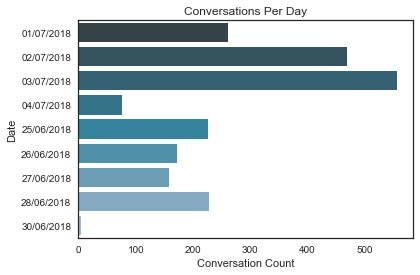

In [8]:
sns.set(style="white", context="notebook")
vis1 = sns.barplot(x = 'Conversation Count', y = 'Date', data = convPerDay, palette="PuBuGn_d").set_title('Conversations Per Day')
plt.savefig('ConversationsPerDay.png', bbox_inches='tight')

---

##### Intent Frequency

In [9]:
intentCount = df.groupby(['Intent_Detected'], as_index=False).count()
intentCount = intentCount.drop(['User_Input', 'Request_TimeStamp','Confidence_Level','Watson_Output'], axis=1)
intentCount.columns =  ['Intent', 'Count']
intentCount = intentCount.sort_values('Count', ascending=False)
intentCount = intentCount[intentCount.Intent != 'No Intent Detected'] # Removing the intents that were not matched

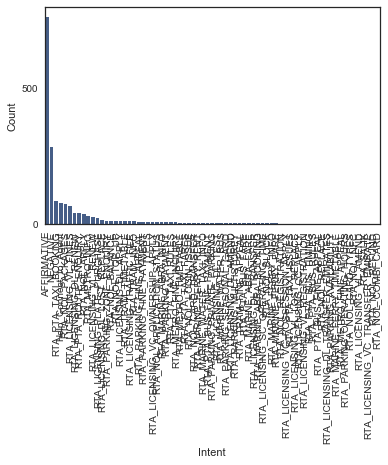

In [10]:
plt.xticks(rotation = 90)

sns.set(rc={'figure.figsize':(50,50)}, font_scale=6, style = 'white')

vis2 = sns.barplot(x = 'Intent' , y = 'Count', data = intentCount, color = "#3b5b92")

plt.savefig('IntentFreq.png', bbox_inches='tight')

---

##### Intents with Low Confidence

In [11]:
lowConf = df[df.Confidence_Level < 40]
lowConf.to_excel(writer, "Low Confidence")
writer.save()

---